### Paper Topic: Model Selection for Gaussian Processes Utilizing Sensitivity of Posterior Predictive Distribution

- Shaan Desai, Spencer Hallyburton, Salvador Barragan

#### Introduction

- Feature selection in machine learning is an important method used to select a subset of the most relevant features for a given response. This is particularly useful, but not limited to, situations in which deep knowledge of the problem domain is unknown or limited and an interpretable, low dimensional model needs to be built.
- Over the years numerous methods have been developed to carry out automatic feature selection such as forward/backward selection, lasso/ridge regression, correlation matrices etc. However, significant research continues to go into feature selection methods since different methods produce different results in high dimensional problems.
- In this discussion we focus on two methods recently presented by Paananen et al for feature selection in Gaussian Process (GP) methods. Their basic idea is to use variations in the posterior predictive distribution with respect to each feature to pick out the relevances of individual features. They present two novel variable selection methods'. The first method (KL) relies on Kullback-Leibler (KL) divergence of the posterior predictive at the training points compared to the training points with one feature slightly perturbed. The second method (VAR) relies on the posterior predictive mean and computes the relevances of each feature based on the variance along a covariate.
- We outline both these methods in detail herein and implement them in GPy, the framework Paananen used to build these models.



#### Background Information

- As a refresher, gaussian processes are a non parametric class of models which define a distribution over functions [Paananen et al].
- priors are functions where $p(f) = N(\mu,K)$ where mu is a vector of means and K is a measure of the covariance matrix with a specific kernel e.g. RBF.
- With a given set of parameters for the kernel one can construct a whole set of functions across numerous data points refered to as latent functions.
- Then, we introduce data. In our case, we introduce training data. The introduction of data is treated as extending the Normal of the prior distribution to include the means and covariances of the specified points s.t.:

$$ \begin{bmatrix} f \\ y \end{bmatrix} \sim N \Bigg(\begin{bmatrix} 0 \\ 0 \end{bmatrix} , \begin{bmatrix} K + \sigma^2I & K_{*}^T \\ K_{*} & K_{**} \end{bmatrix}\Bigg)  $$


The posterior predictive is then simply a conditional which is also gaussian!

$$ P(y|f) = N(\mu_a,\Sigma_a) $$


where:

$$ \mu_a = K_{*}(K+\sigma^2I)^{-1}y $$

$$ \Sigma_{a} = K_{**} -K_{*}(K+\sigma^2I)K_{*}^T $$

- One measure of relevance we can derive from this fitting procedure (through MLE) is Automatic relevance determination, a method we will refer to as the most natural way to determine feature importance. ARD is simply calculated by looking at the optimized RBF kernel length (l) in:

$$k(x,x') = \sigma^2 exp\bigg(-\frac{1}{2} \frac{(x-x')^2}{l^2}\bigg) $$

Using a separate length for each feature (and a hence a separate covariance matrix for each feature) we can determine the ARD by taking the reciprocal of the length scale, l, as a measure of relevance since lower length scales mean highly relevant features. ARD forms the baseline of our experiments as it does in Paananen et al and is a good way to compare the performance of the new methods introduced.

#### Procedure

##### Method 1: KL 

KL divergence is a good metric to determine the difference between two distributions. As such, Paananen et al suggest a unique and simple way to determine feature importance using this divergence on the posterior predictive distribution. Earlier, we mentioned that the posterior predictive distribution in gaussian processes is simply a conditional of P(y,f) which we already know is Gaussian. We can simply take this posterior distribution at the training points X (where X= [$x_1$,$x_2$,....$x_{feature n}$] and is of dimension observations by number of features) and compare it to a posterior predictive distribution in which feature $x_j$ is perturbed by an amount $\Delta$ (~ 0.0001). The idea in doing this is that if the feature $x_j$ is important, then the KL divergence between a distribution with $x_j$ and $x_j + \Delta$ should be high and the higher the divergence the more important the feature. Since both of these posterior distributions will be gaussian with a specific mu and sigma as presented earlier, we can compute the KL analytically in this form:

$$ KL(N1,N2) = log\frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2\sigma_2^2} - 1/2 $$

Simpson et al suggest that a distance between distributions can be computed using:

$$ d = \sqrt{2KL(N1,N2)} $$

and the relevance Paananen develops from this is to simply divide d by $\Delta$ s.t:

$$ KL_{relevance} = \frac{\sqrt{2KL(N1,N2)}}{\Delta} $$


##### Method 2: VAR

The core idea in this method is to use the variance of the posterior predictive mean of a full GP along each covariate as an estimate for the relevance of the covariate. The idea is that we know:

$$ p(y|f) \sim N(\mu_{*},\Sigma_{*}) $$ where
$$ \mu_{*} = K_{*}(K+\sigma^2I)^{-1}y $$

Now imagine that y is one data point e.g. (1 row of 8 features) then posterior predictive mean is calculated using that one row and the training points in f. Now if we ask, what is the variance of this mu then we would need to know the distribution of our features X because mu is basically a function of X. To do this we need to know how our X's are distributed. We assume that these x's are distributed Normally s.t. $X\sim N(\mu,\Sigma)$. But, we can also get more granular than this, since the conditional of this along one covariate is also Normal e.g.

$$ \begin{bmatrix} x_{-j} \\ x_j \end{bmatrix} \sim N \Bigg(\begin{bmatrix} \mu_{-j} \\ \mu_j \end{bmatrix} , \begin{bmatrix} \Sigma_{-j,-j} & \sigma_{j,-j} \\ \sigma_{-j,j} & \sigma_{j,j} \end{bmatrix}\Bigg)  $$


Thus we can take the conditional distribution which is normal:

$$ p(x_j|x_{-j}) = N(\mu_a,\sigma_a^2) $$

where

$$ \mu_a = \mu_j + \sigma_{j,-j} \Sigma_{-j,-j}^{-1} (x_{-j}-\mu_{-j}) $$

$$ \sigma_a^2 = \sigma_{j,j} - \sigma_{j,-j} \Sigma_{-j,-j}^{-1} \sigma_{-j,j} $$


Great, now we have a distribution of the inputs and the distribution of a single input given the others. With this, we can determine the Variance of $\mu_{*}$ with respect to a single covariate/feature. The equation is thus:

$$ Var(\mu_{*}(x_j)) = \int \mu_{*}^2 N(\mu_a,\sigma_a^2) dx_j - \Bigg(\int \mu_{*} N(\mu_a,\sigma_a^2)dx_j\Bigg)^2 $$

With some variable changes we can get:

$$ k = (x_j - \mu_a)/(\sqrt{2}\sigma_a) $$

Thus the variance becomes:


$$ Var(\mu_{*}(x_j)) \approx \pi^{-1/2} \Sigma_{i=1}^n w_i \mu_{*}^2 (\sqrt{2} \sigma_a k_i + \mu_a) - \pi^{-1} ( \Sigma_{i=1}^{n} w_i \mu_{*} (\sqrt{2}\sigma_a k_i + \mu_a))^2 $$

where $w_i$ and $k_i$ are weights and evaluation points of the Gauss-Hermite quadrature.


You can find the paper at:
- https://arxiv.org/pdf/1712.08048.pdf

You can find the toy model here:
- https://github.com/topipa/GP_varsel_KL_VAR/blob/master/demo.py

#### Code







In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import GPy
from tqdm import tqdm
import scipy as scp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#### Initial testing to generate the figures in fig1

In [2]:
#8*1000 random vars, 8 input vectors/features
xjs_unif = np.random.uniform(-1.,1.,(8,300))
xjs_norm = np.random.normal(0,0.4,(8,300))

#8 uniform coefficients of sine function for the 8 functions
phi = np.linspace(np.pi/10,np.pi,8)
#compute input of sines = phij*xj for each j
inp_unif = []
inp_norm = []
for i in range(8):
    inp_unif.append(phi[i]*xjs_unif[i,:])
    inp_norm.append(phi[i]*xjs_norm[i,:])
inp_unif = np.array(inp_unif)
inp_norm = np.array(inp_norm)
sines_unif = np.sin(inp_unif)
sines_norm = np.sin(inp_norm)

#compute function coeffs Aj by finding the std of sin(phij*xj) and taking 1/std(sin(phij*xj))
fjunif = []
fjnorm = []
for i in range(8):
    fjunif.append(sines_unif[i,:]/np.std(sines_unif[i,:]))
    fjnorm.append(sines_norm[i,:]/np.std(sines_norm[i,:]))
fjunif = np.array(fjunif)
fjnorm = np.array(fjnorm)

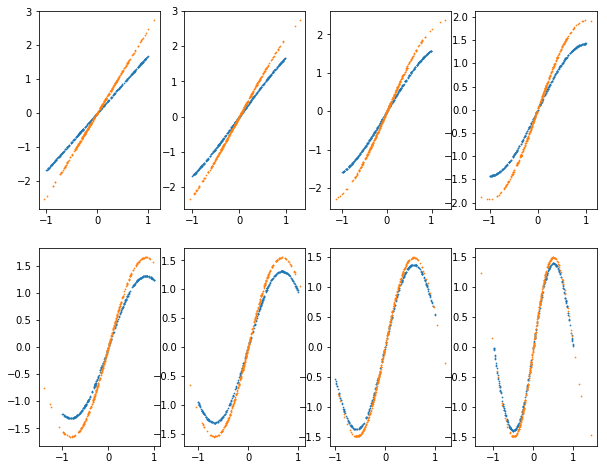

In [3]:
fig,ax = plt.subplots(2,4,figsize=(10,8))
ax = ax.ravel()
for i in range(8):
    ax[i].scatter(xjs_unif[i,:],fjunif[i,:],s=0.5)
    ax[i].scatter(xjs_norm[i,:],fjnorm[i,:],s=0.5)

In the figures above, we fit GP models to data generated from sinusoidal target functions. The blue curves show data with uniformly distributed coefficients, whereas the orange show data with normally distributed coefficients. The figures above will be used to perform feature selection on a toy model with known target outputs.

**NOTE:** If the line below fails to execute, it means that you have an out-of-date "priors.py". Please copy our "priors.py" file into your 'GPy/core/parametrization' folder

In [4]:
GPy.priors.HalfT(A=1,nu=1)

hT(1, 1)

In [6]:
# define both functions to compute relevances
delta = 0.0001

def KLmethod(X,m):
    """computes the KL divergence between original training points and each covariate perturbed
    e.g. X= [x1,x2,..xn] and Xd = [x1+delta,x2,x3..]"""
    # Delta for KL method
    delta = 0.0001
    
    #number of training points
    n = X.shape[0]
    #number of features
    p = X.shape[1]
    
    #loop over training data points and perturb each 
    relsup = np.zeros((n,p))
    relsdn = np.zeros((n,p))
    muorig,varorig = m.predict(X)
    for i in range(p):
        #do positive delta perturbation
        X[:,i] = X[:,i] + delta
        muu,Cu = m.predict(X)
        #negative delta perturb
        X[:,i] = X[:,i] - 2*delta
        mud,Cd = m.predict(X)
        #compute relevances for top and bottom
        relsup[:,i] = rrel_fun(muorig,np.sqrt(varorig),muu,np.sqrt(Cu)).ravel()
        relsdn[:,i] = rrel_fun(muorig,np.sqrt(varorig),mud,np.sqrt(Cd)).ravel()
        #return to original vector
        X[:,i] = X[:,i] + delta
    return np.mean((relsup + relsdn)/2,axis=0)
  
#KL divergence
def KL(mu1,s1,mu2,s2):
    return (np.log(s2/s1) +(s1**2+(mu1-mu2)**2)/(2*s2**2)- 1./2)

    #relevance metric
def rrel_fun(mu1,s1,mu2,s2):
    return (np.sqrt(2*KL(mu1,s1,mu2,s2))/delta)


# Function adapted from Paananen
# https://github.com/topipa/GP_varsel_KL_VAR/blob/master/code/GP_varsel.py
def VARmethod(X,model,nquadr):
    """Computes relevance by looking at variance of posterior predictive mean at x_j, holding x_-j constant"""
    
    # Auxiliary function  
    n = X.shape[0]
    p = X.shape[1]
    relevances = np.zeros(p)
    [points,weights] = np.polynomial.hermite.hermgauss(nquadr)
    
    jitter=1e-14
    
    # full covariance matrix of X plus small jitter on diagonal
    fullcov = np.cov(X,rowvar=False) + jitter*np.eye(p)

    # if condition number is high, add a diagonal term until it goes below 100
    # this is a bit heuristic
    while (np.linalg.cond(fullcov,p=2) > 100):
        jitter = jitter*10
        fullcov = fullcov + jitter*np.eye(p)

    # Cholesky decomposition of the covariance matrix
    cholfull = scp.linalg.cholesky(fullcov,lower=True)

    # loop through covariates
    for j in range(0, p):

        # remove j'th covariate
        jvals = X[:,j]
        nojvals = np.delete(X,(j), axis=1)
        jmean = jvals.mean() 
        nojmean = nojvals.mean(axis=0)

        jcov = fullcov[j,j]
        jnojcov = fullcov[j,:]
        jnojcov = np.delete(jnojcov,(j),axis=0)
        jnojcov = jnojcov.reshape(1,p-1)
        
        # Cholesky decomposition of the submatrix
        cholsub = cholsubmatrix(cholfull,j)
        meanfactor = scp.linalg.cho_solve((cholsub,True),jnojcov.T).T
        intcov = jcov - np.dot(  meanfactor,jnojcov.T)

        # loop through data points
        for k in range(0, n):

            nojtark = nojvals[k,:]
            intmean = jmean + np.dot(meanfactor,(nojtark - nojmean))
            fcalcpoints = np.repeat(X[k,:],nquadr).reshape(p,nquadr).T
            fcalcpoints[:,j] = np.sqrt(2)*np.sqrt(intcov)*points + intmean

            predmean,predvar = GPy.models.GPRegression.predict(model,fcalcpoints,full_cov=False)
            fsquare = predmean*predmean

            # Gauss-Hermite quadrature integration
            relevances[j] += np.dot(fsquare.T,weights)/np.sqrt(np.pi) - np.dot(predmean.T,weights)*np.dot(predmean.T,weights)/np.pi

    return relevances/n

def cholr1update(L,x):
    """Computes a rank-1 update to a Cholesky decomposition"""
    n = np.shape(x)[0]
    for k in np.arange(0,n):
        r = np.sqrt(L[k,k]*L[k,k] + x[k]*x[k])
        c = r / L[k,k]
        s = x[k] / L[k,k]
        L[k,k] = r
        L[k+1:,k] = (L[k+1:,k] + s * x[k+1:]) / c
        x[k+1:] = c * x[k+1:] - s * L[k+1:,k]
    return L

def cholsubmatrix(L,index):
    """Computes the Cholesky decomposition for a submatrix (matrix with one row and one column removed) 
    using the Cholesky of the full matrix"""
    n = np.shape(L)[0]
    chol = np.zeros((n-1,n-1)) 
    chol[:index,:index] = L[:index,:index]
    if (index < n-1):
        chol[index:,:index] = L[index+1:,:index]
        chol[index:,index:] = cholr1update(L[index+1:,index+1:],L[index+1:,index])
    return chol 


##### Toy Model

In [7]:
# number of repetitions to average over
repeats = 200
# number of covariates
m = 8
# number of data points
n = 300
# Delta for KL method
delta = 0.0001
# number of quadrature points for VAR method
#nquadr = 11

# compute the analytical scaling coefficients for the m components for uniform x
phi = np.pi*np.linspace(0.1,1,m);
anaA = np.zeros((m,2))
for i in range(0,m):
    anaA[i,0] = np.sqrt( 4/(2 -1/phi[i]*np.sin(2*phi[i])) )

# coefficient for normally distributed x
nquadr2 = 11
[points,weights] = np.polynomial.hermite.hermgauss(nquadr2)
std = 0.4  
#Anor = np.zeros(m)
for i in range(0, m):
    coeff = np.sin(phi[i]*np.sqrt(2)*std*points)*np.sin(phi[i]*np.sqrt(2)*std*points)
    var = 1.0/np.sqrt(np.pi)*np.dot(coeff.T,weights)
    anaA[i,1] = 1/np.sqrt(var)

    
    
# Input data
x_all = [np.random.uniform(-1.,1.,(n,m,repeats)), np.random.normal(0.,0.4,(n,m,repeats))]
rel_ARD_all = []
rel_KL_all = []
rel_VAR_all = []

# Loop over different types of input data
for ii, x_data in enumerate(x_all):
    rel_ARD_toy = np.zeros(m)
    rel_KL_toy = np.zeros(m)
    rel_VAR_toy = np.zeros(m)
    # Perform the specified number of repeat trials
    for i in tqdm(range(0, repeats)):
        x = x_data[:,:,i]
        
        phi = np.tile(np.linspace(np.pi/10,np.pi,m),(n,1))
        xphi = np.multiply(x[:,0:m],phi)
        f = np.sin(xphi)
        for j in range(0,m):
            f[:,j] = f[:,j]*anaA[j,ii]    

        # y is a sum of the m components plus Gaussian noise
        yval = f.sum(axis=1) + np.random.normal(0,0.3,(n,))
        y = np.asmatrix(yval).T

        # RBF kernel plus constant term
        kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)
        model = GPy.models.GPRegression(x,y,kernel)
        model.optimize()

        # ARD relevance value is the inverse of the length scale
        rel_ARD_toy = rel_ARD_toy + 1/model.sum.rbf.lengthscale

        # KL relevance value
        rel_KL_toy = rel_KL_toy + KLmethod(x,model)

        #var rel
        rel_VAR_toy = rel_VAR_toy + VARmethod(x,model,11)
        
    # Store the relevance measurements
    rel_ARD_all.append(rel_ARD_toy)
    rel_KL_all.append(rel_KL_toy)
    rel_VAR_all.append(rel_VAR_toy)

 56%|████████████████████████████████████████████▊                                   | 112/200 [17:35<13:49,  9.43s/it] C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\GPy\kern\src\stationary.py:136: RuntimeWarning:overflow encountered in square
 C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:invalid value encountered in add
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [11:17<00:00,  3.39s/it]


In [8]:
def plot_relevance(ax, rel_ARD, rel_KL, rel_VAR, title):
    xlength = range(1, len(rel_ARD)+1)
    
    # First axis - Uniform feature inputs
    ax.plot(xlength,np.ones(len(xlength)), '--ko', c='k', label='True Relevance')
    ax.plot(xlength,rel_ARD/rel_ARD.max(),'-o',c='b',label='ARD')
    ax.plot(xlength,rel_KL/rel_KL.max(),'-o',c='r',label='KL')
    ax.plot(xlength,rel_VAR/rel_VAR.max(),'-o',c='purple',label='VAR')
    ax.set_ylabel('Relevance')
    ax.set_title(title)
    ax.set_ylim([0,1.1])
    ax.legend()

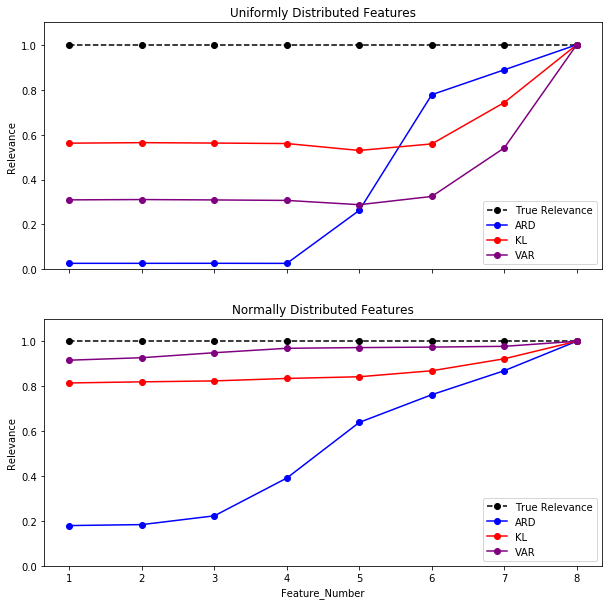

In [9]:
titles=['Uniformly Distributed Features', 'Normally Distributed Features']

# Plotting routines
fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=True)
for i, (rel_ARD_temp, rel_KL_temp, rel_VAR_temp) in enumerate(zip(rel_ARD_all, rel_KL_all, rel_VAR_all)):
    plot_relevance(ax[i], rel_ARD_temp, rel_KL_temp, rel_VAR_temp, titles[i])
plt.xlabel('Feature_Number')
plt.show()

From the figures above we can see that we are able to replicate the results of the paper quite well. Shown in black is the true relevance that we know given the way the data was constructed. The point of this toy script was to show that the two methods do indeed outperform ARD in terms of picking out the features relevant to a problem.

#### Real-World Datasets

Now we move to real world datasets. In this case we want to use our metrics on all features to get an average relevance ordering of the features. Using this information we then calculate the mean log-predictive-density (mlpd) values for subsets of the full model with the most important features in order. In essence, we are simply sequentially dropping the least relevant features and creating a fit and determining the mlpd values with respect to each of the three rankings.

Note that our choice of priors (different from the ones used by Topi) were:

$$ \sigma_f \sim Half-T(1,1) $$

$$ \epsilon \sim Half-T(1,1) $$

$$ l_i \sim Inv-Gamma(1,1) $$

In order to use the GPy implementation of these priors we had to go into the priors folder within the library and make alterations for the code to work since the GPy authors committed priors that were not working. We have attached priors.py which you should copy and replace within GPy/Core/Parametrization.

The Gaussian Process model architecture for this procedure is similar to that of the toy model. First, we normalize the input data such that it has zero mean and unit variance along each of the columns of data. Then we fit the model over our training data and calculate MLPD outputs for the the testing data. In between, we calculate the relevance ordering of the covariates of the full model.

In [9]:
def preprocess_data(X, y):
    # Normalize the data
    X = preprocessing.scale(X)
    y = preprocessing.scale(y)
    
    # Train-test split on the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22)

    # If y_train is one dimensional, reshape it as 2
    if len(y_train.shape)==1:
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
        
    return X_train, X_test, y_train, y_test 

In [10]:
def perform_GP_fitting(X, y):
    
    # number of repetitions to average over
    repeats = 10

    # Train-test split (only for getting dimensions, will be repeated every iteration)
    Xdata, Xtest, ydata, ytest = preprocess_data(X, y)

    # Get sizes of data
    n, m = Xdata.shape
    n2, m2 = Xtest.shape

    # Initialize arrays for results
    rel_ARD = np.zeros(m)
    rel_KL = np.zeros(m)
    rel_VAR = np.zeros(m)

    # Initialize place to store output
    nmetrics = 3
    mlpd = np.zeros((m, nmetrics, repeats))
    
    # Priors:
    var_prior = GPy.priors.HalfT(A=1.0, nu=1.0)
    noise_prior = GPy.priors.HalfT(A=1., nu=1.0)
    len_prior = GPy.priors.InverseGamma(a=1., b=1.)
    collector = []
    
    # Run the full model:
    print('Testing full model')
    for i in range(0, repeats):
        
        # Split the data now for every repitition
        Xdata, Xtest, ydata, ytest = preprocess_data(X, y)

        # RBF kernel plus constant term
        kernel = GPy.kern.RBF(input_dim=m,ARD=True) + GPy.kern.Bias(input_dim=m)

        # Initialize the model
        model = GPy.models.GPRegression(Xdata, ydata, kernel)
        # Set the priors
        model.sum.rbf.lengthscale.set_prior(len_prior);
        model.sum.rbf.variance.set_prior(var_prior);
        model.Gaussian_noise.variance.set_prior(noise_prior);
        
        # Optimize the model
        model.optimize()

        # ARD relevance value is the inverse of the length scale
        rel_ARD = rel_ARD + 1/model.sum.rbf.lengthscale
        
        # KL relevance value
        rel_KL = rel_KL + KLmethod(Xdata,model)

        #var rel
        rel_VAR = rel_VAR + VARmethod(Xdata,model,20)

        # Calculate the predictive density
        mlpd[-1, :, i] = np.mean(model.log_predictive_density(Xtest, ytest))
        collector.append((rel_ARD,rel_KL,rel_VAR)) 
    #return collector
    # Calculate the ordering and run the model over all of the different orders
    print('Testing Covariates')
    for j, sort_rel_metric in enumerate([rel_ARD, rel_KL, rel_VAR]):
        print(j)

        # Get the ordering for this model
        #ordering = np.argsort(sort_rel_metric)  is this the reverse order?? 
        ordering = list(reversed(np.argsort(sort_rel_metric)))
        print(ordering)

        # Loop in reverse over the number of features except for the full model
        for nfeat in reversed(range(1,m)):
            print('Number of Features:', nfeat)

            # Reslice the data based on the ordering:
            X_sub = X.values[:, ordering[:nfeat]]

            # Perform the specified number of repeat trials
            for i in range(0, repeats):
                
                # Split the data now for every repitition
                Xdata, Xtest, ydata, ytest = preprocess_data(X_sub, y.values)
                
                # RBF kernel plus constant term
                kernel = GPy.kern.RBF(input_dim=nfeat,ARD=True) + GPy.kern.Bias(input_dim=nfeat)
                model = GPy.models.GPRegression(Xdata, ydata, kernel)

                # Set the priors
                model.sum.rbf.lengthscale.set_prior(len_prior);
                model.sum.rbf.variance.set_prior(var_prior);
                model.Gaussian_noise.variance.set_prior(noise_prior);

                model.optimize()

                # Make the predictions:
                mlpd[nfeat-1, j, i] = np.mean(model.log_predictive_density(Xtest, ytest))
    return collector, mlpd

In [11]:
def plot_mlpd(ax, mlpd, title):
    ax.errorbar(list(range(1,mlpd.shape[0]+1)), mlpd[:,0,:].mean(axis=1), yerr=mlpd[:,0,:].std(axis=1), c='b', label='ARD')
    ax.errorbar(list(range(1,mlpd.shape[0]+1)), mlpd[:,1,:].mean(axis=1), yerr=mlpd[:,1,:].std(axis=1), c='r', label='KL')
    ax.errorbar(list(range(1,mlpd.shape[0]+1)), mlpd[:,2,:].mean(axis=1), yerr=mlpd[:,2,:].std(axis=1), c='purple', label='VAR')
    ax.set_title(title)
    ax.set_ylabel('MLPD')
    ax.legend()

#### Concrete Dataset

We first will analyze the concrete dataset. This dataset is extracted from the University of California Irvine dataset for machine learning. It contains indicators of different numbers of concrete metrics with the goal of predicting a slump rate, flow rate, and compressive strenght. In this model, we consider 7 predictive features with the output target predicting compressive strength of the concrete.

In [12]:
# Concrete Data
data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/slump/slump_test.data'
df_concrete = pd.read_csv(data_link)
df_concrete.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


In [13]:
# Concrete data
X_concrete = df_concrete.iloc[:,1:-3]
y_concrete = df_concrete.iloc[:,-1]
print('Data Shape:', X_concrete.shape)
collector,mlpd_concrete = perform_GP_fitting(X_concrete, y_concrete)
#collector = perform_GP_fitting(X_concrete, y_concrete)

reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance


Data Shape: (103, 7)
Testing full model


 /anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning:invalid value encountered in sqrt
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaus

Testing Covariates
0
[3, 6, 0, 2, 1, 5, 4]
Number of Features: 6


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 5


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 4


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 3


reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regressio

Number of Features: 2


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 1


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

1
[0, 2, 3, 1, 6, 4, 5]
Number of Features: 6


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 5


reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regressio

Number of Features: 4


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 3


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 2


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 1


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_re

2
[5, 2, 0, 3, 6, 1, 4]
Number of Features: 6


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 5


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 4


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 3


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 2


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

Number of Features: 1


reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regression.sum.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.sum.rbf.lengthscale
reconstraining parameters GP_regres

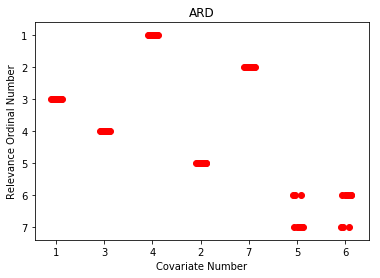

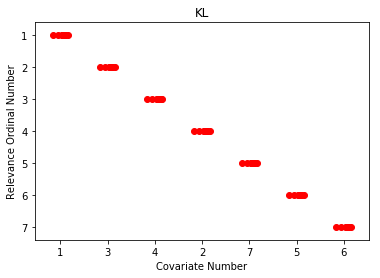

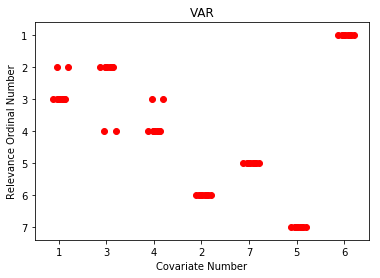

In [14]:
#plots fig 4 from the paper for concrete dataset
xs = [1,3,4,2,7,5,6]
features = np.array([1,2,3,4,5,6,7])
titlenames = ['ARD','KL','VAR']
def mapper(a):
    temp = []
    for i,xvals in enumerate(xs):
        temp.append(np.where(a==xvals))
    return(np.array(temp).ravel())
labelvals = ['ARD','KL','VAR']
for j,title in enumerate(titlenames):
    plt.figure()
    for i in range(len(collector)):
        a = np.array(list(reversed(np.argsort(collector[i])[j])))+1
        plt.scatter(features+np.random.normal(0,0.1),mapper(a)+1,c='r')
    plt.xticks(range(1,8),xs)
    plt.xlabel('Covariate Number')
    plt.ylabel('Relevance Ordinal Number')
    plt.title(title)
    plt.gca().invert_yaxis()
        

In the above plots, we have plotted the relevance of each covariance number as a function of the covariate to get a sense of how consistent or inconsistent the model was at establishing a relevance order from one repitition to the next. The main thing we observe in this set of three figures is that the KL method consistenly produces the same ranking for its features in the numerous runs. We see that ARD also does this with the exception of the final two covariates.

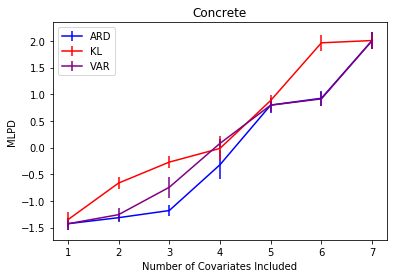

In [32]:
# Plot results
fig, ax = plt.subplots(1,1)
plot_mlpd(ax, mlpd_concrete, 'Concrete')
plt.xlabel('Number of Covariates Included')
plt.show()

The above figure shows the mean log-predictive density as a function of the number of covariate included in the model. We expect that all three relevance ordering schemes will produce the exact same MLPD when all 7 covariates are included in the model. Error bars at each covariate index are gathered from a standard deviation calculation over the number of repititions of this procedure with shuffled test and train data.

We notice in the ARD ordering that it is highly sensitive to the priors and its ordering results in much weaker performance for lower covariate indices as can be seen in the figure above. The variance method does also result in significant variations across iterations in terms of the ordering which is not consistent with the results in the paper but it does depend on the parameters chosen and we are not certain what Topi et al used.

Regardless of this, we can see that KL and Var methods perform as well as or better than ARD in terms of selecting the most important features and returning their order. You are free to test out other datasets (which we have included below) and corroborate results with the paper to see whether the methods are consistent across other real world problems.

Below are additional datasets for you to play with. we would like to acknowledge Topi Paananen for his help in reconstructing some of the figures.

In [16]:
# # Boston Housing data
# data_link='https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
# colnames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
# df_Boston = pd.read_csv(data_link, delim_whitespace=True, header=None)
# df_Boston.columns = colnames
# df_Boston.head()

In [17]:
# X_Boston = df_Boston.iloc[:,:-1]
# y_Boston = df_Boston.iloc[:,-1]
# print('Data Shape:', X_Boston.shape)
# print('Output Shape:', y_Boston.shape)
# mlpd_Boston = perform_GP_fitting(X_Boston,y_Boston)

In [18]:
# # Plot Boston housing
# fig, ax = plt.subplots(1,1)
# plot_mlpd(ax, mlpd_Boston, 'Boston Housing')
# plt.xlabel('Covariate Index')
# plt.show()

In [19]:
# # NOTE: CRIME DATA IS VERY LARGE AND TAKES TOO LONG WITHOUT SAMPLING METHODS
# # Crime data
# data_link = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
# df_crime = pd.read_csv(data_link, delim_whitespace=False, header=None)

# # Drop the 4th column because it is strings only
# df_crime = df_crime.drop(columns=[3])

# # Replace '?' with nan
# df_crime = df_crime.replace({'?': np.nan})

# # Convert to numeric
# df_crime = df_crime.apply(pd.to_numeric, args=('coerce',))

# # Fill missing with mean imputation:
# df_crime = df_crime.apply(lambda x: x.fillna(x.mean()),axis=0)

# df_crime = df_crime.sample(n=300, random_state=10)

# print('Data Shape:', df_crime.shape)
# df_crime.head()

In [20]:
# # Run the GP model on this dataset:
# X_crime = df_crime.iloc[:,:-1]
# y_crime= df_crime.iloc[:,-1]
# print('Data Shape:', X_crime.shape)
# print('Output Shape:', y_crime.shape)
# mlpd_crime = perform_GP_fitting(X_crime,y_crime)

In [21]:
# # Plot crime data
# fig, ax = plt.subplots(1,1)
# plot_mlpd(ax, mlpd_crime, 'Crime')
# plt.xlabel('Covariate Index')
# plt.show()

In [22]:
# data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
# df_cars = pd.read_csv(data_link, delim_whitespace=True, header=None)

# # Initial size:
# print('Initial Size:', df_cars.shape)

# # Drop the last column because it's string
# df_cars = df_cars.drop(columns=[8])

# # Replace '?' with nan
# df_cars = df_cars.replace({'?': np.nan})

# # Drop imputation
# df_cars = df_cars.dropna()
# print('Final Size:', df_cars.shape)

# # Print the head
# df_cars.head()

In [23]:
# X_cars = df_cars.iloc[:,1::]
# y_cars = df_cars.iloc[:,0]
# print('Data Shape:', X_cars.shape)
# print('Output Shape:', y_cars.shape)
# mlpd_cars = perform_GP_fitting(X_cars,y_cars)

In [24]:
# # Plot car data
# fig, ax = plt.subplots(1,1)
# plot_mlpd(ax, mlpd_cars, 'Cars')
# plt.xlabel('Covariate Index')
# plt.show()

In [25]:
# # Read in the data
# df_facebook = pd.read_csv('dataset_Facebook.csv', delimiter=';')

# # Convert second column to categorical indices
# df_facebook = df_facebook.drop(columns=['Type'])

# # Print data shape
# print('Shape of Data', df_facebook.shape)

# # Fill nans 
# df_facebook = df_facebook.dropna()

# df_facebook.head()

In [26]:
# X_facebook = df_facebook.drop(columns=['Page total likes'])
# y_facebook = df_facebook['Page total likes']

# print('Data Shape:', X_facebook.shape)
# print('Output Shape:', y_facebook.shape)
# mlpd_facebook = perform_GP_fitting(X_facebook,y_facebook)

In [27]:
# # Plot facebook data
# fig, ax = plt.subplots(1,1)
# plot_mlpd(ax, mlpd_facebook, 'Facebook')
# plt.xlabel('Covariate Index')
# plt.show()

In [28]:
# data_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data'
# df_park = pd.read_csv(data_link, delim_whitespace=False)

# # Take a subsample of this data for regression (just to reduce the data size)
# df_park = df_park.sample(n=300, random_state=10)

# # Size:
# print(df_park.shape)
# df_park.head()

In [29]:
# X_park = df_park.drop(columns=['motor_UPDRS','total_UPDRS'])
# y_park = df_park['total_UPDRS']

# print('Data Shape:', X_park.shape)
# print('Output Shape:', y_park.shape)
# mlpd_park = perform_GP_fitting(X_park,y_park)

In [30]:
# # Plot parkinson data
# fig, ax = plt.subplots(1,1)
# plot_mlpd(ax, mlpd_park, 'Parkinson Data')
# plt.xlabel('Covariate Index')
# plt.show()

In [31]:
# # Plot all together
# mlpd_all = [mlpd_concrete, mlpd_Boston]
# fig, ax_full = plt.subplots(2,1, figsize=(6,6))
# titles =['Concrete', 'Boston Housing']
# # Plot the MLPD estimates for each of the datasets
# for ax2, mlpd, title in zip(ax_full, mlpd_all, titles):
#     plot_mlpd(ax2, mlpd, title)
# plt.xlabel('Number of Covariates')
# plt.show()